In [1]:
import os
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt

# Set working directory
os.chdir(r"..") # should be the git repo root directory
cwd = os.getcwd()
print("Current working directory: " + cwd)
assert os.getcwd()[-8:] == "WattCast", "Current working directory is not the git repo root directory"


Current working directory: e:\GitHub\Forked_Repos\WattCast


In [34]:
from timezonefinder import TimezoneFinder
import requests

def get_weather_data(lat, lng, start_date, end_date, variables:list, keep_UTC = True):

    '''
    This function fetches weather data from the Open Meteo API and returns a dataframe with the weather data.

    Parameters

    lat: float
        Latitude of the location
    lng: float
        Longitude of the location
    start_date: str
        Start date of the weather data in the format YYYY-MM-DD
    end_date: str
        End date of the weather data in the format YYYY-MM-DD
    variables: list
        List of variables to fetch from the API.
    keep_UTC: bool
        If True, the weather data will be returned in UTC. If False, the weather data will be returned in the local timezone of the location.

    Returns

    df_weather: pandas.DataFrame
        Dataframe with the weather data
    '''
    
    if keep_UTC:
        tz = 'UTC'
    else:
        print('Fetching timezone from coordinates')
        tf = TimezoneFinder()
        tz = tf.timezone_at(lng=lng, lat=lat)
    
    df_weather = pd.DataFrame()
    for variable in variables:
        response = requests.get('https://archive-api.open-meteo.com/v1/archive?latitude={}&longitude={}&start_date={}&end_date={}&hourly={}'.format(lat, lng, start_date, end_date, variable))
        df = pd.DataFrame(response.json()['hourly'])
        df = df.set_index('time')
        df_weather = pd.concat([df_weather, df], axis=1)

    df_weather.index = pd.to_datetime(df_weather.index)
    df_weather = df_weather.tz_localize('UTC').tz_convert(tz)

    return df_weather

df_weather = get_weather_data(
    45.515757, -122.610689, '2021-01-01', '2022-01-01', ['temperature_2m'], keep_UTC = False
)
df_weather['datetime'] = df_weather.index.tz_localize(None)
df_weather.reset_index(inplace=True, drop=True)


Fetching timezone from coordinates


In [47]:
df_weather.drop_duplicates()

,temperature_2m,datetime
0,8.2,2020-12-31 16:00:00
1,7.4,2020-12-31 17:00:00
2,6.8,2020-12-31 18:00:00
3,6.9,2020-12-31 19:00:00
4,7.0,2020-12-31 20:00:00
...,...,...
8779,-1.9,2022-01-01 11:00:00
8780,-0.6,2022-01-01 12:00:00
8781,0.5,2022-01-01 13:00:00
8782,1.3,2022-01-01 14:00:00


In [54]:
# Replace 'your_file_path.csv' with the actual path to your CSV file
df = pd.read_csv(os.path.join(cwd, 'data', 'raw_data', 'Portland_load_profile.csv'))
start_date = '2021-01-01 00:00:00'
end_date = pd.to_datetime(start_date) + pd.DateOffset(hours=8759)
datetime_series = pd.date_range(start=start_date, end=end_date, freq='H')
df['datetime'] = datetime_series
df.drop(columns=['Date/Time'], inplace=True)
print(f"==>> len(df): {len(df)}")
df.to_csv(os.path.join(cwd, 'data', 'clean_data', 'Portland.csv'), index=False)

==>> len(df): 8760


In [55]:
# Assuming your CSV file has two columns: 'timestamp' and 'value'
# Adjust the column names accordingly to match your dataset
time_series = TimeSeries.from_dataframe(df, 'datetime', ['Electric_MW', 'Temperature'])


In [56]:
print(f"==>> time_series.width: {time_series.width}")
time_series = time_series.add_datetime_attribute(attribute='weekday', cyclic=True).add_datetime_attribute(attribute='day', cyclic=True).add_datetime_attribute(attribute='month', cyclic=True)
print(f"==>> time_series.width: {time_series.width}")

==>> time_series.width: 2
==>> time_series.width: 8


In [57]:
# time_series.add_holidays(country_code='US', prov='CA')['holidays']

print(f"==>> time_series.start_time(): {time_series.start_time()}")
print(f"==>> time_series.end_time(): {time_series.end_time()}")

time_series.gaps()

==>> time_series.start_time(): 2021-01-01 00:00:00
==>> time_series.end_time(): 2021-12-31 23:00:00


,gap_start,gap_end


In [68]:
import torch
from torch.utils.data import Dataset, DataLoader
from darts import TimeSeries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class TimeSeriesDataset(Dataset):
    def __init__(self, data, history_length=5, forecast_length=2):
        self.data = data
        self.history_length = history_length
        self.forecast_length = forecast_length

    def __getitem__(self, index):
        # Get the historical data and target values for the current index
        history = self.data[index:index+self.history_length].values()
        target = self.data[index+self.history_length:index+self.history_length+self.forecast_length].values()

        return history, target

    def __len__(self):
        return len(self.data) - self.history_length - self.forecast_length + 1


# df_t = pd.read_csv('E:/GitHub/Forked_Repos/WattCast/df_tt.csv')
df_t = pd.read_csv('E:/GitHub/Forked_Repos/WattCast/data/clean_data/Portland.csv')
# Assuming your DataFrame is named 'df' with columns 'datetime' and 'value'
series = TimeSeries.from_dataframe(df_t, 'datetime', ['Electric_MW', 'Temperature'])
series = TimeSeries.from_dataframe(df_t, 'datetime', ['Electric_MW'])

# Define the seasonal chunks
num_chunks = 4
chunk_length = len(series) // num_chunks

# Define the split percentages for each chunk
split_pcts = [0.7, 0.2, 0.1]

# Initialize lists to store the split datasets
train_chunks = []
val_chunks = []
test_chunks = []

# Split the dataset into chunks and apply split percentages
for i in range(num_chunks):
    start_index = i * chunk_length
    end_index = (i + 1) * chunk_length

    chunk = series[start_index:end_index]

    split_sizes = np.array(split_pcts) * len(chunk)
    train_chunk = chunk[:int(split_sizes[0])]
    val_chunk = chunk[int(split_sizes[0]):int(split_sizes[0] + split_sizes[1])]
    test_chunk = chunk[int(split_sizes[0] + split_sizes[1]):]

    train_chunks.append(train_chunk)
    val_chunks.append(val_chunk)
    test_chunks.append(test_chunk)

# Concatenate the chunks back together
train_series = train_chunks[0]
val_series = val_chunks[0]
test_series = test_chunks[0]

# for i in range(1, num_chunks):
#     train_series += train_chunks[i]
#     val_series += val_chunks[i]
#     test_series += test_chunks[i]

train_dataset = TimeSeriesDataset(train_series)
val_dataset = TimeSeriesDataset(val_series)
test_dataset = TimeSeriesDataset(test_series)

# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


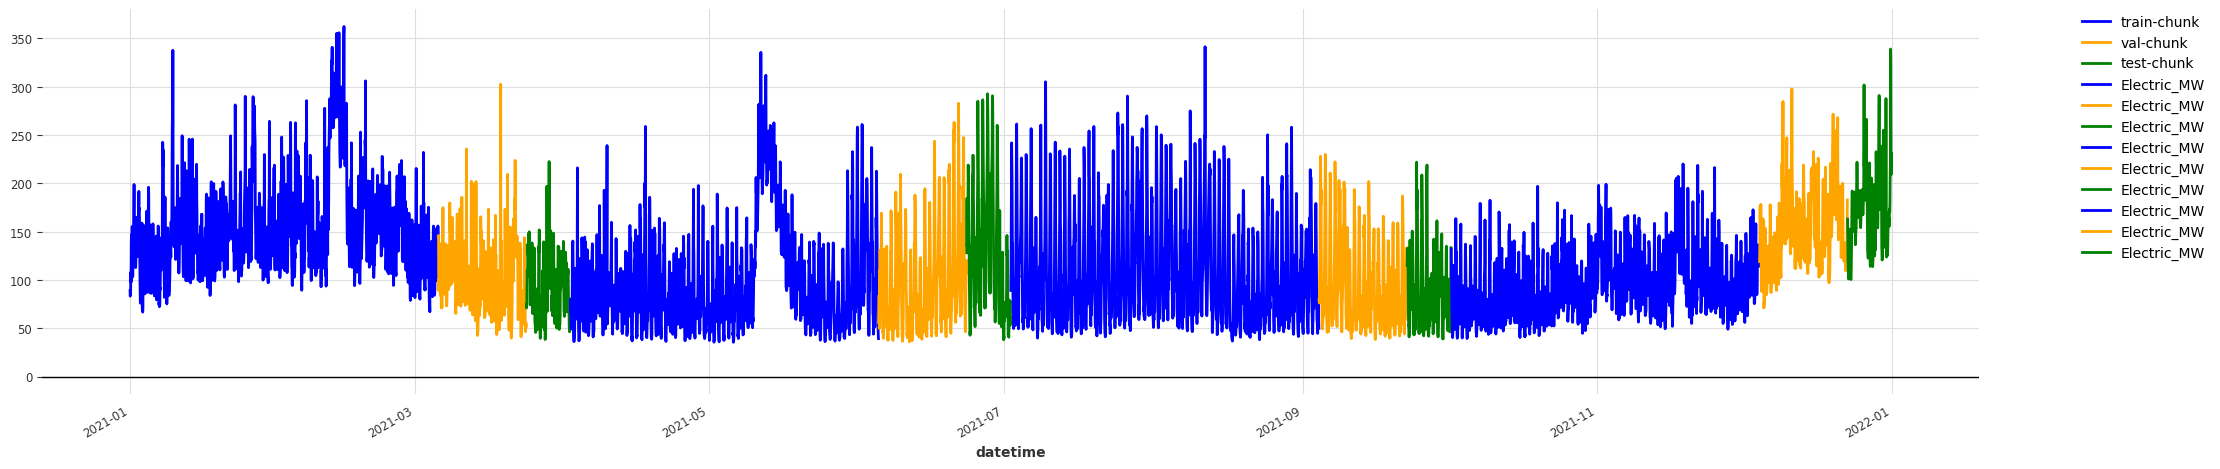

In [72]:
import torch
from torch.utils.data import Dataset, DataLoader
from darts import TimeSeries
import numpy as np
import pandas as pd
from pprint import pprint

class TimeSeriesDataset(Dataset):
    def __init__(self, data_list, history_length=5, forecast_length=2):
        self.data_list = data_list
        self.history_length = history_length
        self.forecast_length = forecast_length
        self.lengths = [len(data) - history_length - forecast_length + 1 for data in self.data_list]

    def __getitem__(self, index):
        # Find the corresponding time series chunk and index within the chunk
        cum_lengths = np.cumsum(self.lengths)
        chunk_index = np.searchsorted(cum_lengths, index + 1)
        if chunk_index == 0:
            data_index = index
        else:
            data_index = int(index - cum_lengths[chunk_index - 1])

        print(f"==>> item_index: {index}, chunk_index: {chunk_index}, data_index: {data_index}")
        # Get the historical data and target values for the current index
        history = self.data_list[chunk_index][data_index:data_index+self.history_length].values().copy()
        target = self.data_list[chunk_index][data_index+self.history_length:data_index+self.history_length+self.forecast_length].values().copy()

        return history, target

    def __len__(self):
        return sum(self.lengths)



# df = pd.read_csv('E:/GitHub/Forked_Repos/WattCast/df_tt.csv', parse_dates=['datetime'])
df = pd.read_csv('E:/GitHub/Forked_Repos/WattCast/df_t.csv', parse_dates=['datetime'])

# Assuming your DataFrame is named 'df' with columns 'datetime' and 'value'
series = TimeSeries.from_dataframe(df, 'datetime', 'Electric_MW')

# Define the seasonal chunks
num_chunks = 4
chunk_length = len(series) // num_chunks

# Define the split percentages for each chunk
split_pcts = [0.7, 0.2, 0.1]

# Initialize lists to store the split datasets
train_chunks = []
val_chunks = []
test_chunks = []

# Split the dataset into chunks and apply split percentages
for i in range(num_chunks):
    start_index = i * chunk_length
    end_index = (i + 1) * chunk_length

    chunk = series[start_index:end_index]

    split_sizes = np.array(split_pcts) * len(chunk)
    train_chunk = chunk[:int(split_sizes[0])]
    val_chunk = chunk[int(split_sizes[0]):int(split_sizes[0] + split_sizes[1])]
    test_chunk = chunk[int(split_sizes[0] + split_sizes[1]):]

    train_chunks.append(train_chunk)
    val_chunks.append(val_chunk)
    test_chunks.append(test_chunk)

# Concatenate the chunks back together
train_dataset = TimeSeriesDataset(train_chunks, history_length=24, forecast_length=4)
val_dataset = TimeSeriesDataset(val_chunks, history_length=24, forecast_length=4)
test_dataset = TimeSeriesDataset(test_chunks, history_length=24, forecast_length=4)

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


plt.figure(figsize=(25, 5))

for i in range(num_chunks):
    # Only add legend labels for the first chunk
    if i == 0:
        train_chunks[i].plot(color='blue', label='train-chunk')
        val_chunks[i].plot(color='orange', label='val-chunk')
        test_chunks[i].plot(color='green', label='test-chunk')
    else:
        # Hide the labels for the other chunks
        train_chunks[i].plot(color='blue')
        val_chunks[i].plot(color='orange')
        test_chunks[i].plot(color='green')


# Move legend to the right, outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Show plot axes lines
plt.axhline(0, color='black', lw=1)


In [73]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

6024
1644
768


### Whole workflow

In [75]:
def get_train_val_test_chunks(df, num_chunks=4, split_pcts=[0.7, 0.2, 0.1]):
    assert abs(sum(split_pcts)-1.0)<1e-6, "Split percentages must sum to 1.0"
    # Assuming your DataFrame is named 'df' with columns 'datetime' and 'value'
    series = TimeSeries.from_dataframe(df, 'datetime', ['Electric_MW', 'Temperature'])
    chunk_length = len(series) // num_chunks

    # Initialize lists to store the split datasets
    train_chunks = []
    val_chunks = []
    test_chunks = []

    # Split the dataset into chunks and apply split percentages
    for i in range(num_chunks):
        start_index = i * chunk_length
        end_index = (i + 1) * chunk_length

        chunk = series[start_index:end_index]

        split_sizes = np.array(split_pcts) * len(chunk)
        train_chunk = chunk[:int(split_sizes[0])]
        val_chunk = chunk[int(split_sizes[0]):int(split_sizes[0] + split_sizes[1])]
        test_chunk = chunk[int(split_sizes[0] + split_sizes[1]):]

        train_chunks.append(train_chunk)
        val_chunks.append(val_chunk)
        test_chunks.append(test_chunk)

    return train_chunks, val_chunks, test_chunks


df = pd.read_csv('E:/GitHub/Forked_Repos/WattCast/data/clean_data/Portland.csv', parse_dates=['datetime'])
train_chunks, val_chunks, test_chunks = get_train_val_test_chunks(df)

==>> sum(split_pcts): 0.9999999999999999


In [79]:
tt = train_chunks[0]

In [83]:
tt.columns

Index(['Electric_MW', 'Temperature'], dtype='object', name='component')